Generic Dataset Information

Repeated charge and discharge cycles result in accelerated aging of the batteries while impedance measurements provide insight into the internal battery parameters that change as aging progresses.

    Charge profile:
        The charge profile for all battery tests seems to be identifical.
        Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA.

    Discharge:
        Discharge profiles were different from battery to battery.
        Discharge was carried out at a constant current (CC) level of 1-4 A until the battery voltage fell to values such 2.7V, 2.5V, 2.2V and 2.5V.

    Impedance:
        Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz.

The experiments were stopped when the batteries reached a given end-of-life (EOL) criteria: for example 30% fade in rated capacity (from 2Ahr to 1.4Ahr). Other stopping criteria were used such as 20% fade in rated capacity. Note that for batteries 49,50,51,52, the experiments were not stop due to battery EOL but because the software has crashed.


Structure of .mat files

    dictionary (loaded mat file)
        dictionary (e.g. B0005)
            list (cycle) -> one test per element in the list
                element of the list = dict = all data for one test of that battery
                    type: operation type, can be charge, discharge or impedance
                    ambient_temperature: ambient temperature (degree C)
                    time: the date and time of the start of the cycle, in MATLAB date vector format
                    data (dict): data structure containing the measurements
                        data fields with key being measured variable, values the actual records (see below)

    for charge the fields are:
        Voltage_measured: Battery terminal voltage (Volts) -> terminal voltage is the voltage or potential difference between the positive and the negative terminals of the battery
        Current_measured: Battery output current (Amps)
        Temperature_measured: Battery temperature (degree C)
        Current_charge: Current measured at charger (Amps)
        Voltage_charge: Voltage measured at charger (Volts)
        Time: Time vector for the cycle (secs)
    for discharge the fields are:
        Voltage_measured: Battery terminal voltage (Volts)
        Current_measured: Battery output current (Amps)
        Temperature_measured: Battery temperature (degree C)
        Current_load: Current measured at load (Amps)
        Voltage_load: Voltage measured at load (Volts)
        Time: Time vector for the cycle (secs)
        Capacity: Battery capacity (Ahr) for discharge till 2.7V
    for impedance the fields are:
        Sense_current: Current in sense branch (Amps)
        Battery_current: Current in battery branch (Amps)
        Current_ratio: Ratio of the above currents
        Battery_impedance: Battery impedance (Ohms) computed from raw data
        Rectified_impedance: Calibrated and smoothed battery impedance (Ohms)
        Re: Estimated electrolyte resistance (Ohms)
        Rct: Estimated charge transfer resistance (Ohms)

Differences between README files

    discharge CC level
    discharge runs stopped voltage
    EOL criteria (30% -> 1.4 Ah, 20% -> 1.6 Ah, software crash)


In [2]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

In [3]:
def load_mat(filepath):
    return sio.loadmat(filepath, simplify_cells=True)

## Battery Analysis and Predictions

In [4]:
def get_charge_discharge_df(battery_cycles):
    charge_dfs = []
    discharge_dfs = []
    impedance_dfs = []

    c = 0
    d = 0
    i = 0

    for cycle_number in range(len(battery_cycles)):
        cycle_type = battery_cycles[cycle_number]['type']
        cycle_data = battery_cycles[cycle_number]['data']

        if cycle_type == 'charge':
            c = c + 1

            df = pd.DataFrame({
                'Cycle': c,  # Add the cycle number as a column
                'Time': cycle_data['Time'],
                'Voltage_measured': cycle_data['Voltage_measured'],
                'Current_measured': cycle_data['Current_measured'],
                'Temperature_measured': cycle_data['Temperature_measured'],
                'Current_charge': cycle_data['Current_charge'],
                'Voltage_charge': cycle_data['Voltage_charge'],
            })

            charge_dfs.append(df)

        if cycle_type == 'discharge':
            d = d + 1

            df = pd.DataFrame({
                'Cycle': d,
                'Time': cycle_data['Time'],
                'Voltage_measured': cycle_data['Voltage_measured'],
                'Current_measured': cycle_data['Current_measured'],
                'Temperature_measured': cycle_data['Temperature_measured'],
                'Current_charge': cycle_data['Current_load'],
                'Voltage_charge': cycle_data['Voltage_load'],
                'Capacity': cycle_data['Capacity']
            })

            discharge_dfs.append(df)

        if cycle_type == 'impedance':
            i = i + 1

            df = pd.DataFrame({
                'Test': i,
                'Sense_current': cycle_data['Sense_current'],
                'Battery_current': cycle_data['Battery_current'],
                'Current_ratio': cycle_data['Current_ratio'],
                'Battery_impedance': cycle_data['Battery_impedance'],
                # 'Rectified_impedance': cycle_data['Rectified_impedance'],
                'Re': cycle_data['Re'],
                'Rct': cycle_data['Rct']
            })

            impedance_dfs.append(df)

    charge_df = pd.concat(charge_dfs, ignore_index=True)
    discharge_df = pd.concat(discharge_dfs, ignore_index=True)
    initial_capacity = discharge_df['Capacity'].iloc[0]
    discharge_df['SOH'] = discharge_df['Capacity'] / initial_capacity

    impedance_df = pd.concat(impedance_dfs, ignore_index=True)

    return charge_df, discharge_df, impedance_df

In [5]:
battery_list = ['B0005', 'B0006', 'B0007', 'B0018']


def get_battery_dictionary(battery_list):
    battery_dict = {}

    for battery_name in battery_list:
        battery_data = load_mat(f'data/{battery_name}.mat')
        battery_cycles = battery_data[battery_name]['cycle']

        charge_df, discharge_df, impedance_df = get_charge_discharge_df(battery_cycles)

        battery_dict[f'{battery_name}_charge'] = charge_df
        battery_dict[f'{battery_name}_discharge'] = discharge_df
        battery_dict[f'{battery_name}_impedance'] = impedance_df

    return battery_dict

In [6]:
battery_dict = get_battery_dictionary(battery_list)
battery_dict.keys()

dict_keys(['B0005_charge', 'B0005_discharge', 'B0005_impedance', 'B0006_charge', 'B0006_discharge', 'B0006_impedance', 'B0007_charge', 'B0007_discharge', 'B0007_impedance', 'B0018_charge', 'B0018_discharge', 'B0018_impedance'])

In [7]:
battery_dict['B0005_charge']

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753
...,...,...,...,...,...,...,...
541168,170,0.000,0.236356,-0.003484,23.372048,0.000,0.003
541169,170,2.547,0.003365,-0.001496,23.369434,0.000,0.003
541170,170,5.500,4.985137,0.000506,23.386535,0.000,5.002
541171,170,8.312,4.984720,0.000442,23.386983,-0.002,5.002


In [8]:
battery_dict['B0005_discharge']

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,SOH
0,1,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487,1.000000
1,1,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487,1.000000
2,1,35.703,3.974871,-2.012528,24.389085,-1.9982,3.062,1.856487,1.000000
3,1,53.781,3.951717,-2.013979,24.544752,-1.9982,3.030,1.856487,1.000000
4,1,71.922,3.934352,-2.011144,24.731385,-1.9982,3.011,1.856487,1.000000
...,...,...,...,...,...,...,...,...,...
50280,168,2781.312,3.579262,-0.001569,34.864823,0.0006,0.000,1.325079,0.713756
50281,168,2791.062,3.581964,-0.003067,34.814770,0.0006,0.000,1.325079,0.713756
50282,168,2800.828,3.584484,-0.003079,34.676258,0.0006,0.000,1.325079,0.713756
50283,168,2810.640,3.587336,0.001219,34.565580,0.0006,0.000,1.325079,0.713756


## Changes to battery state of health over cycles 

In [9]:
def get_max_dfs(battery_dictionary):
    max_dfs = []
    max_charge_dfs = []
    max_discharge_dfs = []

    for battery_name, battery_data in battery_dictionary.items():
        battery_df = battery_data

        if "impedance" not in battery_name:
            max_df = battery_df.loc[battery_df.groupby('Cycle')['Time'].idxmax()]
            max_dfs.append(max_df)

            if "_charge" in battery_name:
                max_charge_dfs.append(max_df)

            if "_discharge" in battery_name:
                max_discharge_dfs.append(max_df)

    return max_dfs, max_charge_dfs, max_discharge_dfs

In [149]:
colors = {
    (0.65, 0.7): 'blue',
    (0.7, 0.75): 'lightblue',
    (0.75, 0.8): 'aqua',
    (0.8, 0.85): 'lightgreen',
    (0.85, 0.9): 'green',
    (0.9, 0.95): 'y',
    (0.95, 1): 'yellow',
}


def plot_max_discharge_dfs(max_discharge_dfs, ncols=2):
    nrows = (len(max_discharge_dfs) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()

    for i, max_discharge_df in enumerate(max_discharge_dfs):
        ax = axes[i]

        for (lower, upper), color in colors.items():
            mask = (max_discharge_df['SOH'] >= lower) & (max_discharge_df['SOH'] < upper)
            ax.scatter(
                max_discharge_df[mask]['Cycle'],
                max_discharge_df[mask]['Capacity'],
                c=color,
                label=f'{lower} - {upper}',
                alpha=0.7
            )
            
        battery_name = 'B0018'

        if i == 0 or i == 1 or i == 2:
            battery_name = f'B000{5 + i}'

        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity')
        ax.set_title(f'Scatter Plot of Cycle vs. Capacity for Battery {battery_name}')
        ax.legend(title='SOH Ranges')

    plt.tight_layout()
    plt.show()

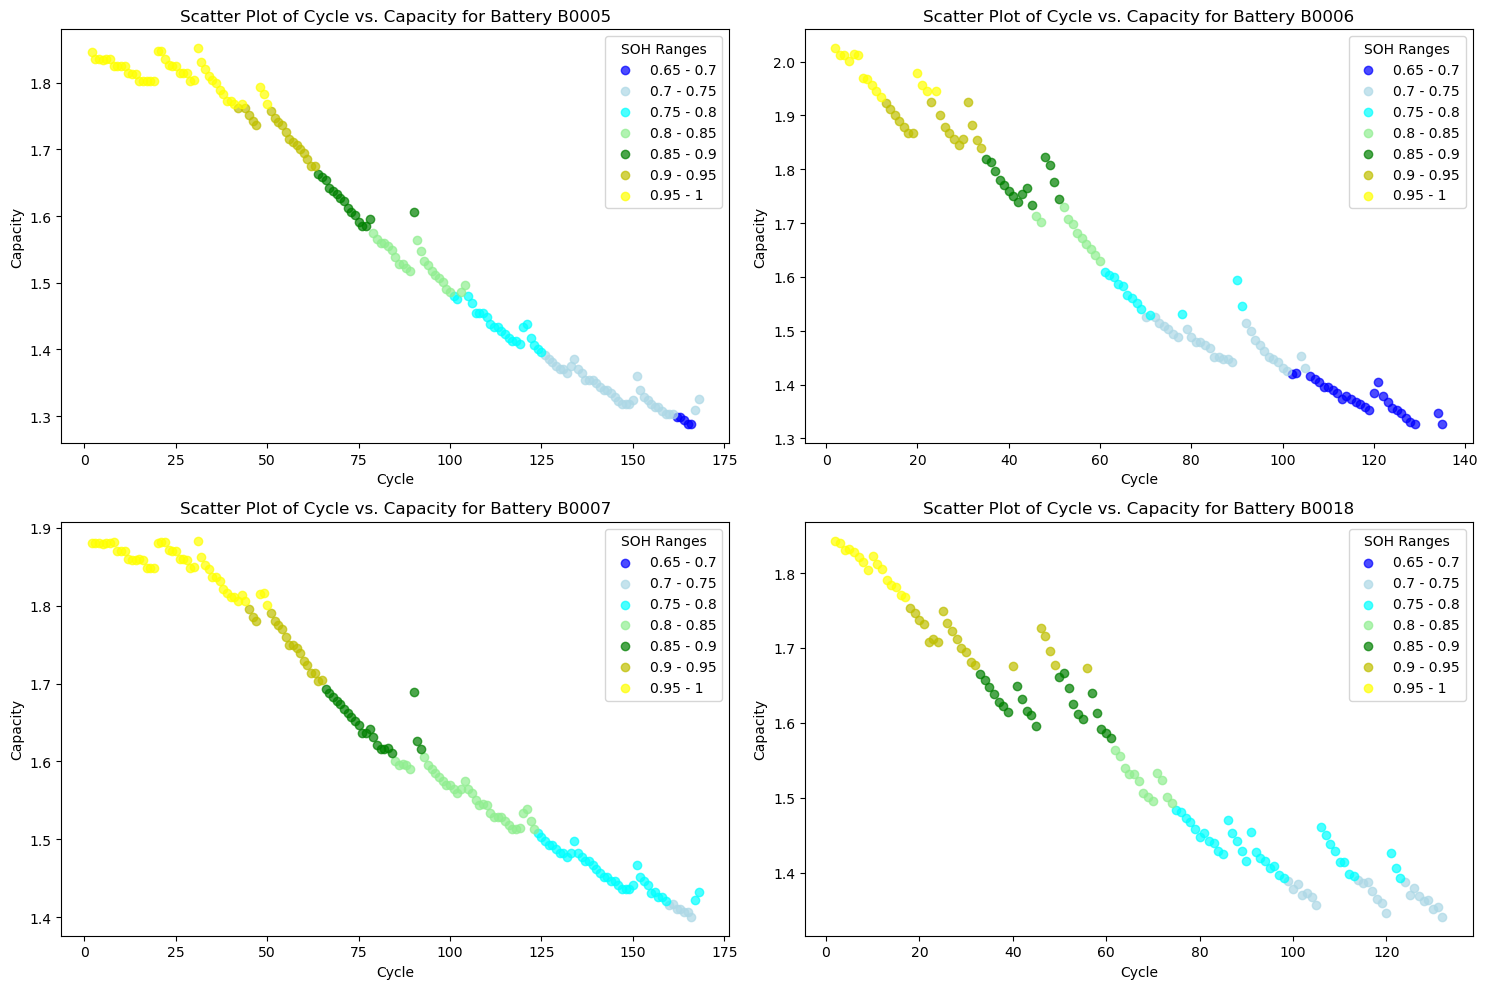

In [150]:
_, _, max_discharge_dfs = get_max_dfs(battery_dict)
plot_max_discharge_dfs(max_discharge_dfs)

## Battery charge and discharge voltage and current measured

In [12]:
def get_voltage_current_plot(battery='B0005', type='charge', kind='voltage'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    battery_df = battery_dict[f'{battery}_{type}']

    ax.scatter(
        battery_df['Cycle'],
        battery_df['Time'],
        battery_df[f'{kind.title()}_measured'],
        c=battery_df['Cycle'],
        cmap='viridis'
    )

    ax.set_title(f'3D Plot of {kind.title()} during {type.title()}')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('Time')
    ax.set_zlabel(kind.title())

    ax.view_init(elev=15, azim=20)

    plt.show()

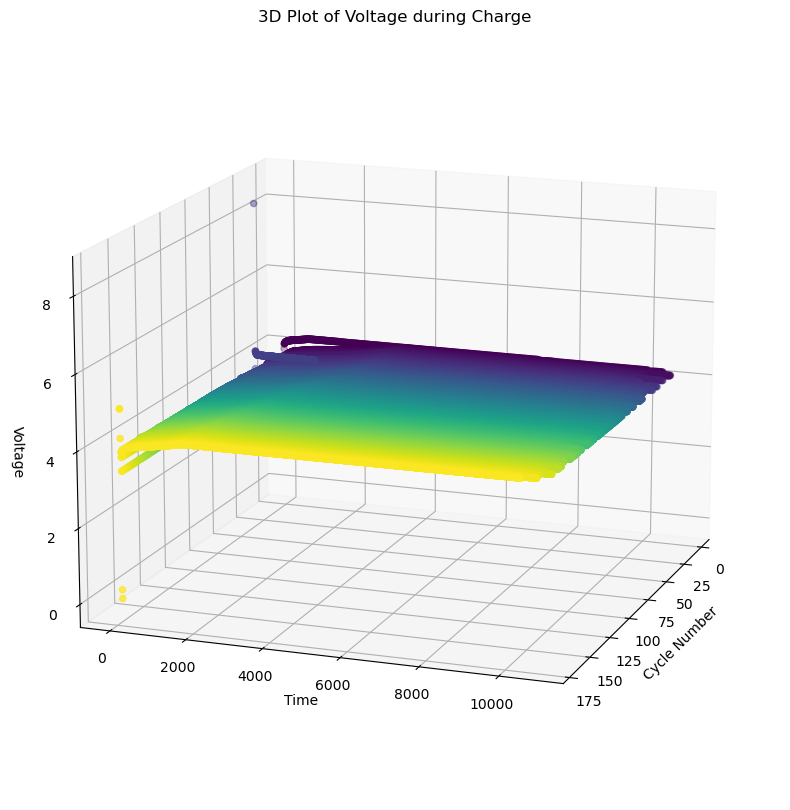

In [13]:
get_voltage_current_plot('B0005', 'charge', 'voltage')

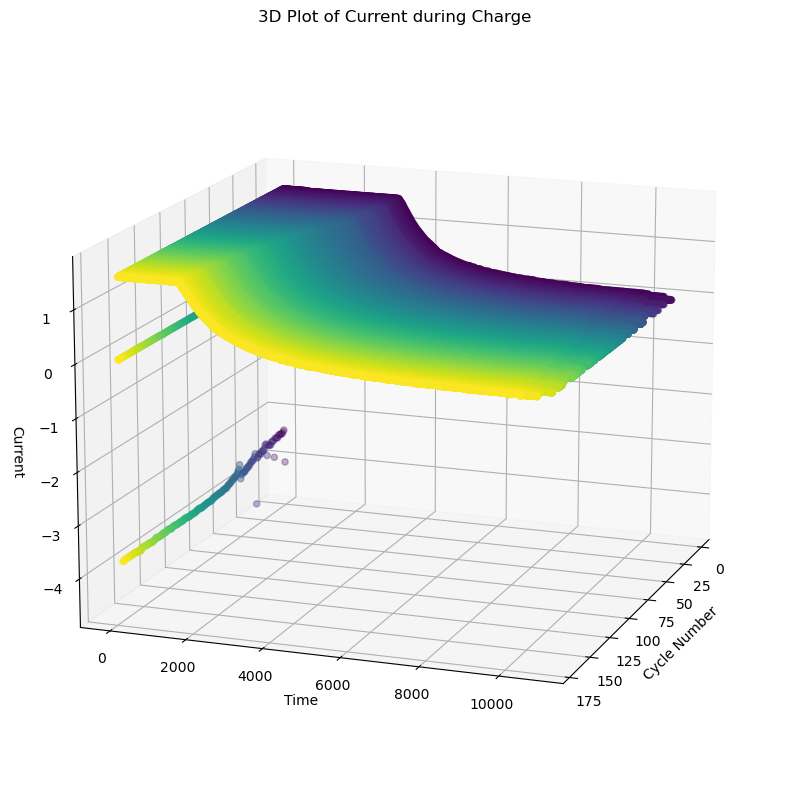

In [14]:
get_voltage_current_plot('B0005', 'charge', 'current')

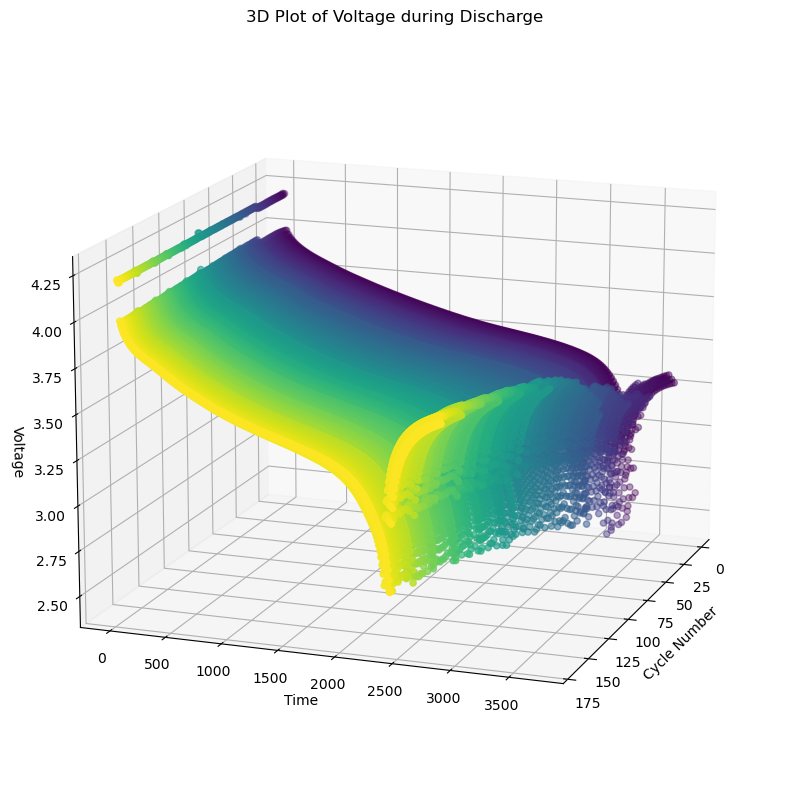

In [15]:
get_voltage_current_plot('B0005', 'discharge', 'voltage')

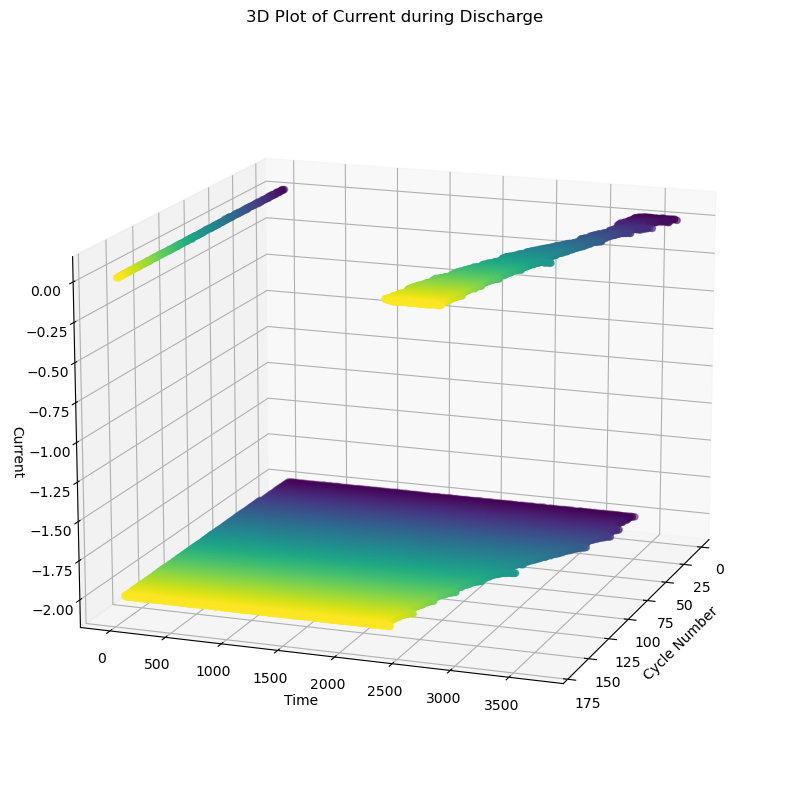

In [16]:
get_voltage_current_plot('B0005', 'discharge', 'current')

## Changes to battery capacity over cycles 

In [106]:
def get_capacity_plot(battery='B0005'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    battery_df = battery_dict[f'{battery}_discharge']

    ax.scatter(
        battery_df['Cycle'],
        battery_df['Time'],
        battery_df['Capacity'],
        c=battery_df['Cycle'],
        cmap='viridis'
    )

    ax.set_title(f'3D Plot of Capacity during Discharge')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('Time')
    ax.set_zlabel('Capacity')

    ax.view_init(elev=15, azim=-50)

    plt.show()

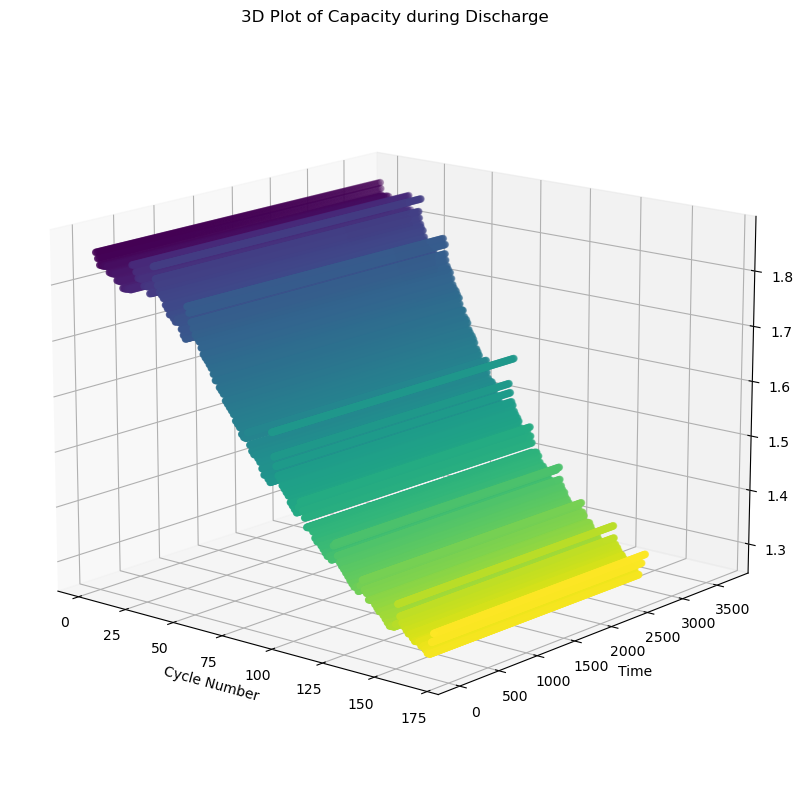

In [107]:
get_capacity_plot('B0005')

## Comparing the first and last voltage/current for all the batteries

In [17]:
def get_first_last_voltage_plot(batteries=['B0005'], type='charge', kind='voltage', cycles=(1, 2)):
    num_batteries = len(batteries)
    rows = (num_batteries + 1) // 2

    plt.figure(figsize=(14, 4 * rows))

    for idx, battery in enumerate(batteries):
        battery_df = battery_dict[f'{battery}_{type}']
        last_cycle = cycles[1]

        if last_cycle not in battery_df['Cycle'].values:
            last_cycle = battery_df['Cycle'].max()

        cycle_first_df = battery_df[battery_df['Cycle'] == cycles[0]]
        cycle_last_df = battery_df[battery_df['Cycle'] == last_cycle]

        plt.subplot(rows, 2, idx + 1)

        plt.plot(cycle_first_df['Time'], cycle_first_df[f'{kind.title()}_measured'], 'b', label='First Cycle')
        plt.plot(cycle_last_df['Time'], cycle_last_df[f'{kind.title()}_measured'], 'r', label='Last Cycle')

        plt.title(f'{battery} First-Last {kind.title()} Plot')
        plt.xlabel('Time')
        plt.ylabel(f'{kind.title()}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

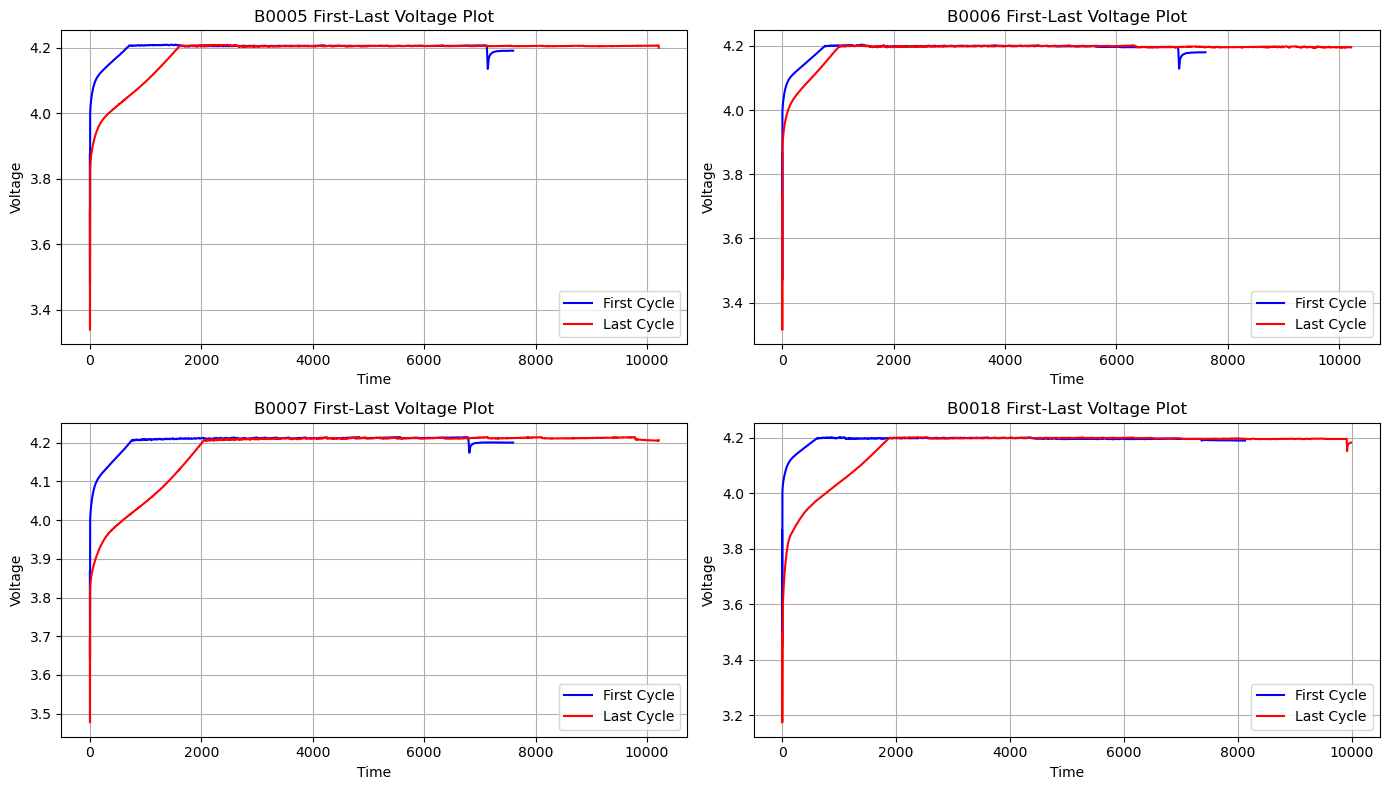

In [18]:
get_first_last_voltage_plot(battery_list, 'charge', 'voltage', (1, 169))

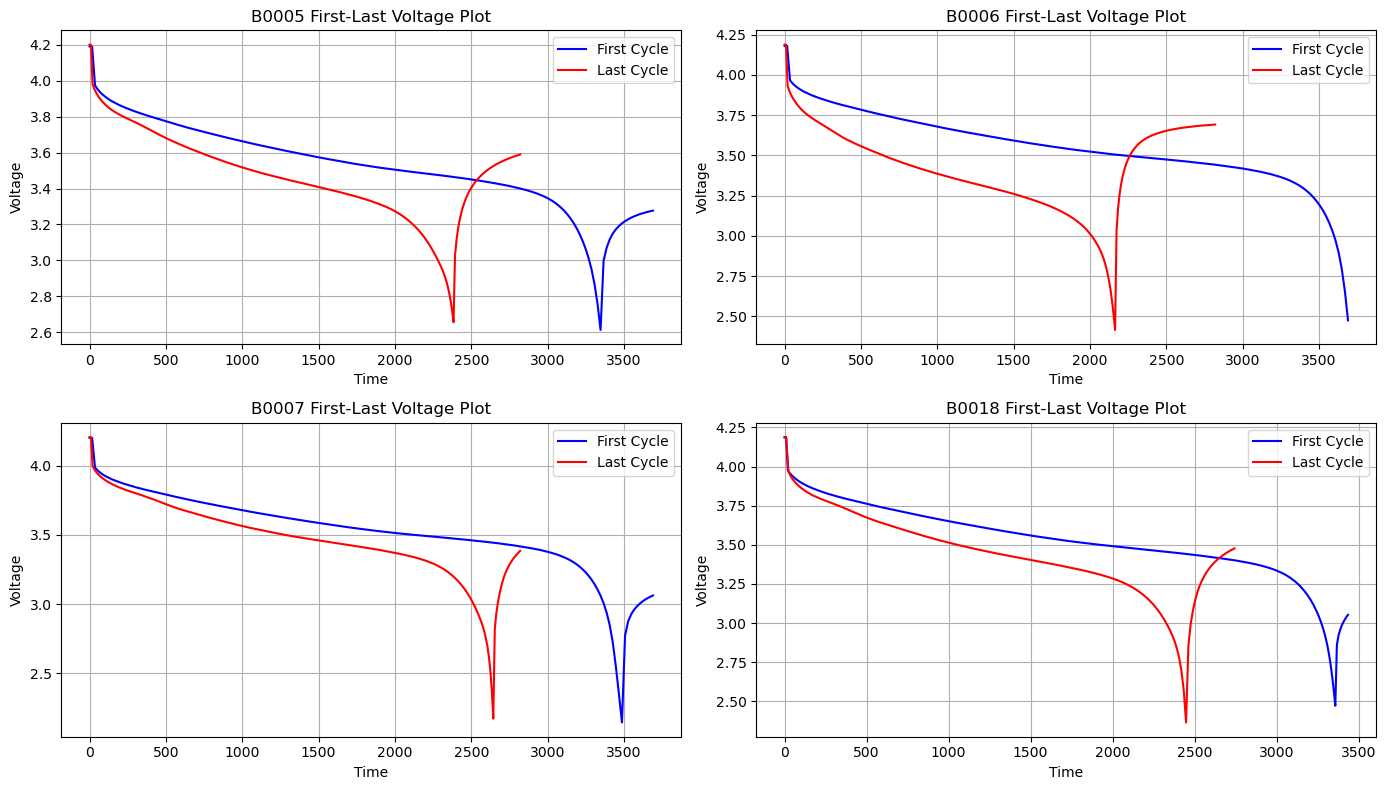

In [19]:
get_first_last_voltage_plot(battery_list, 'discharge', 'voltage', (1, 168))

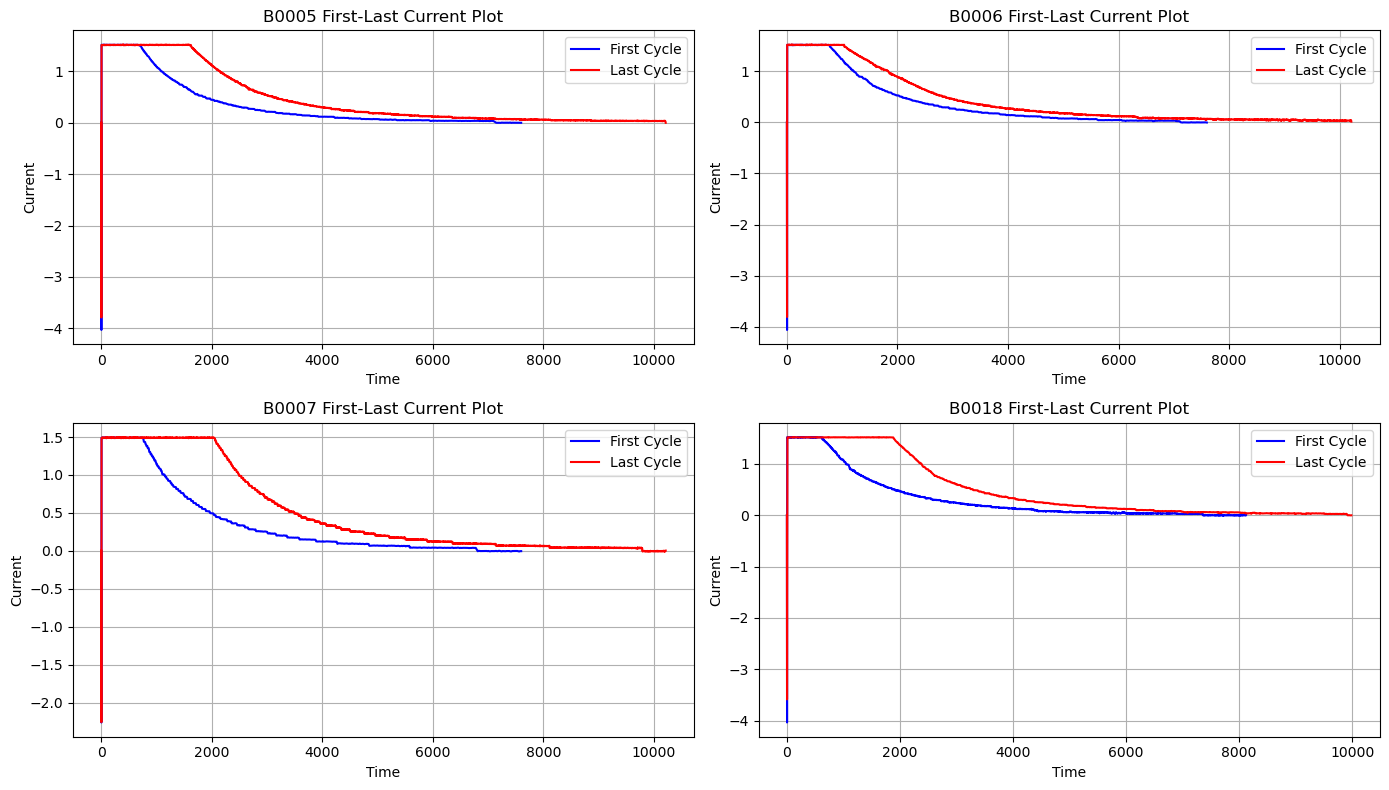

In [20]:
get_first_last_voltage_plot(battery_list, 'charge', 'current', (1, 169))

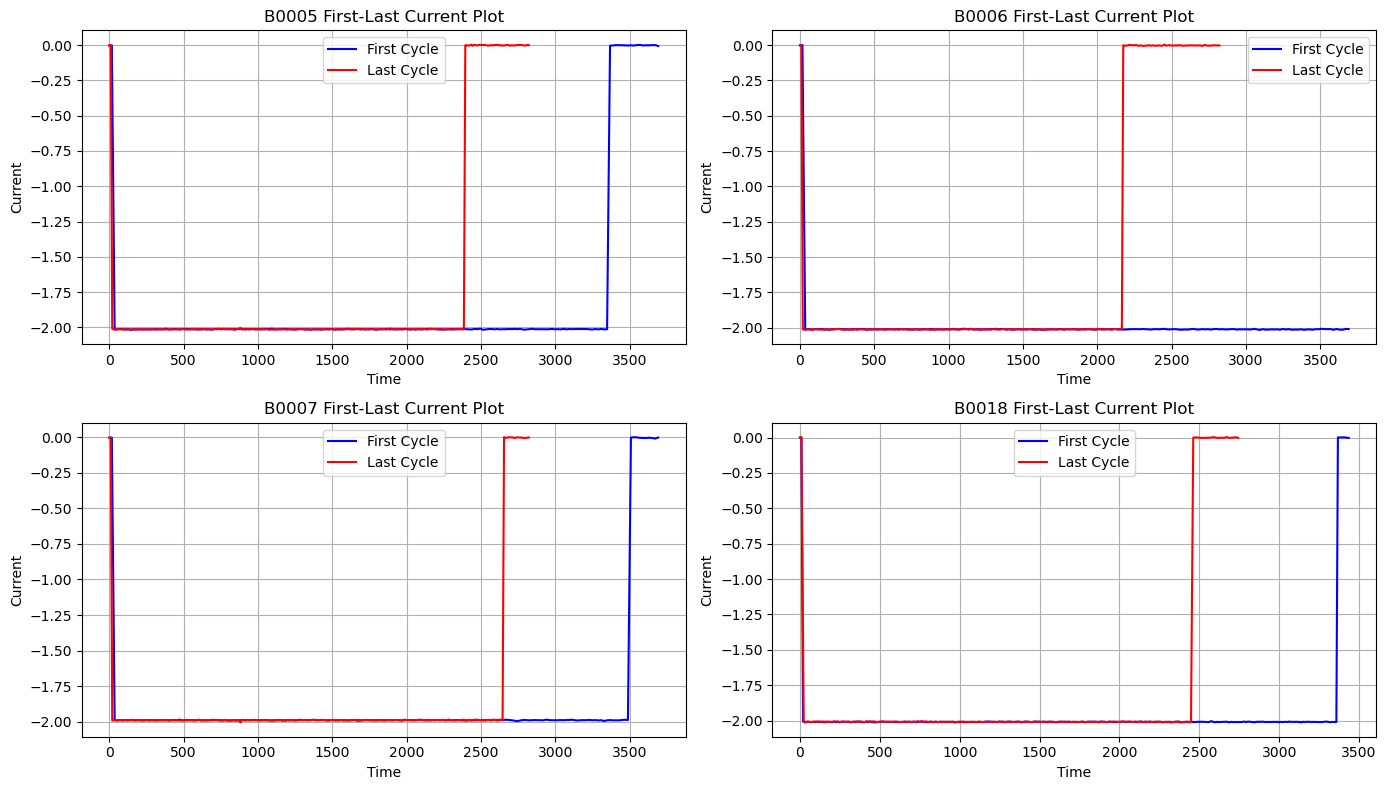

In [21]:
get_first_last_voltage_plot(battery_list, 'discharge', 'current', (1, 168))

## Comparing the impedance for all the batteries

In [22]:
def get_re_rct_plot(batteries=['B0005']):
    num_batteries = len(batteries)
    rows = (num_batteries + 1) // 2

    plt.figure(figsize=(14, 4 * rows))

    for idx, battery in enumerate(batteries):
        battery_df = battery_dict[f'{battery}_impedance']

        plt.subplot(rows, 2, idx + 1)

        plt.plot(battery_df['Test'], battery_df['Re'], 'g', label='Electrolyte Resistance')
        plt.plot(battery_df['Test'], battery_df['Rct'], 'b', label='Charge Transfer Resistance')

        plt.title(f'{battery} Re & Rct Plot')
        plt.xlabel('Test')
        plt.ylabel('Ohms')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

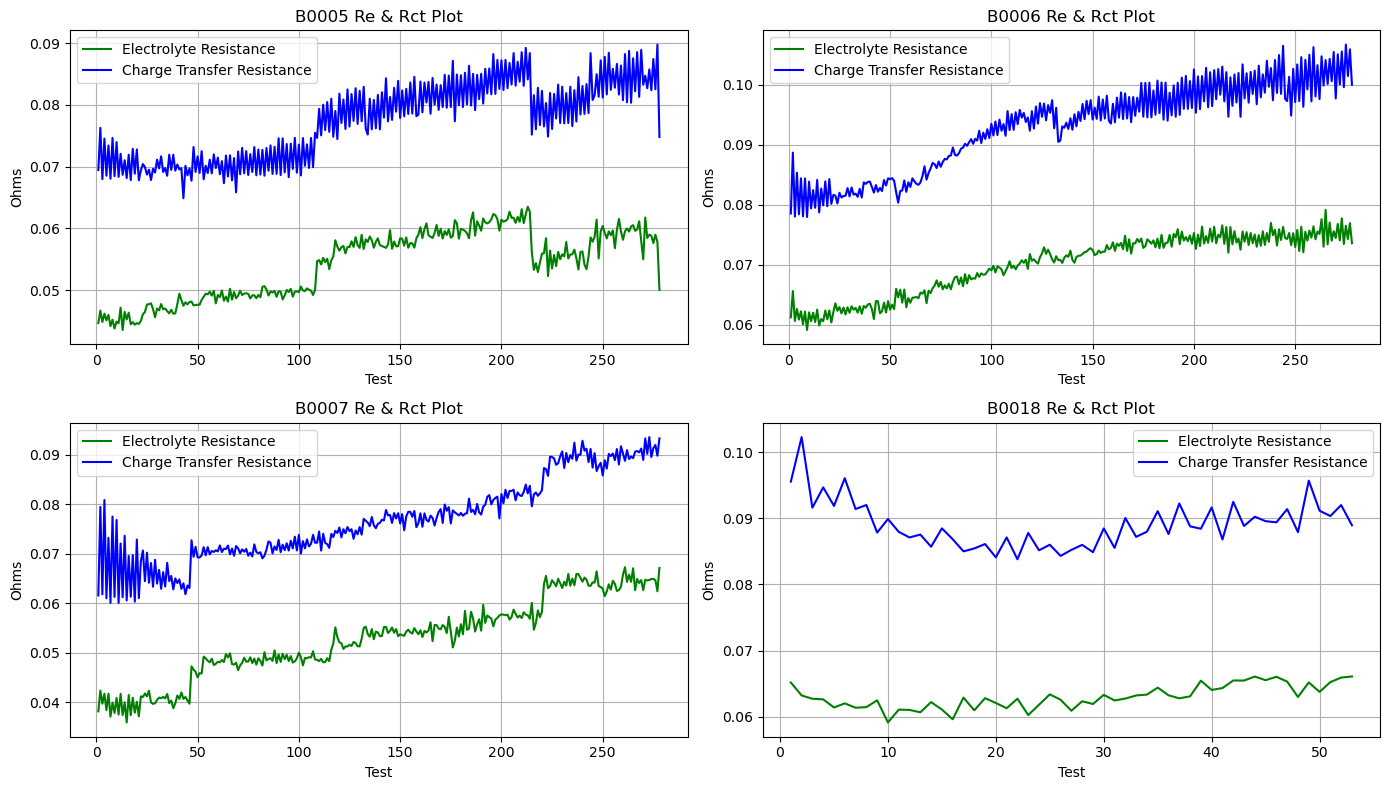

In [23]:
get_re_rct_plot(battery_list)

In [24]:
def get_first_last_impedance_plot(batteries=['B0005'], tests=(1, 2)):
    num_batteries = len(batteries)
    rows = (num_batteries + 1) // 2

    plt.figure(figsize=(14, 4 * rows))

    for idx, battery in enumerate(batteries):
        battery_df = battery_dict[f'{battery}_impedance']

        first_test_df = battery_df[battery_df['Test'] == tests[0]].copy()
        last_test = tests[1] if tests[1] in battery_df['Test'].values else battery_df['Test'].max()
        last_test_df = battery_df[battery_df['Test'] == last_test].copy()

        first_test_df.loc[:, 'Battery_impedance_real'] = np.real(first_test_df['Battery_impedance'].astype(complex))
        last_test_df.loc[:, 'Battery_impedance_real'] = np.real(last_test_df['Battery_impedance'].astype(complex))

        first_test_df.loc[:, 'Sample'] = np.arange(1, len(first_test_df) + 1)
        last_test_df.loc[:, 'Sample'] = np.arange(1, len(last_test_df) + 1)

        plt.subplot(rows, 2, idx + 1)
        plt.plot(first_test_df['Sample'], first_test_df['Battery_impedance_real'], 'b', label='First Test')
        plt.plot(last_test_df['Sample'], last_test_df['Battery_impedance_real'], 'r', label='Last Test')

        plt.title(f'{battery} First-Last Impedance Plot')
        plt.xlabel('Sample')
        plt.ylabel('Ohms')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

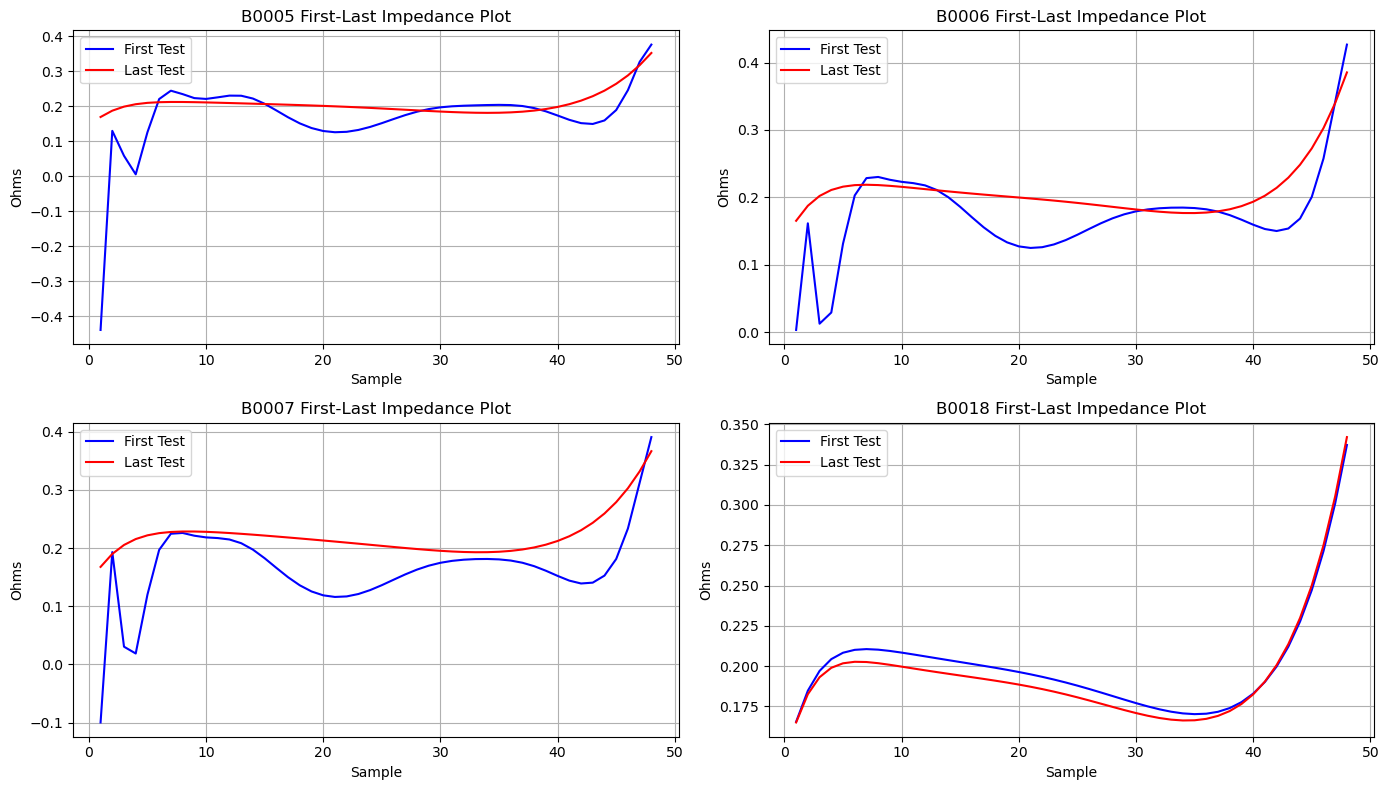

In [25]:
get_first_last_impedance_plot(battery_list, tests=(1, 278))

## Battery 5 Modelling

In [26]:
b5_discharge_df = battery_dict['B0005_discharge']
max_discharge_df = b5_discharge_df.loc[b5_discharge_df.groupby('Cycle')['Time'].idxmax()]
max_discharge_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,SOH
196,1,3690.234,3.277170,-0.006528,34.230853,-0.0006,0.0,1.856487,1.000000
392,2,3672.344,3.300245,-0.000448,34.392137,-0.0006,0.0,1.846327,0.994527
587,3,3651.641,3.327451,0.001026,34.232779,-0.0006,0.0,1.835349,0.988614
781,4,3631.563,3.314182,-0.002234,34.413450,-0.0006,0.0,1.835263,0.988567
975,5,3629.172,3.305497,0.000009,34.345885,-0.0006,0.0,1.834646,0.988235
...,...,...,...,...,...,...,...,...,...
49092,164,2793.390,3.615561,-0.002548,34.075649,0.0006,0.0,1.293464,0.696726
49389,165,2793.390,3.621191,-0.002460,33.991350,0.0006,0.0,1.288003,0.693785
49686,166,2792.485,3.619185,0.000478,34.059198,0.0006,0.0,1.287453,0.693488
49984,167,2802.016,3.595365,-0.002342,34.556514,0.0006,0.0,1.309015,0.705103


In [27]:
y = max_discharge_df['SOH']
X = max_discharge_df.drop(['SOH', 'Capacity', 'Cycle'], axis=1)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')  # You can use other kernels like 'linear' or 'poly' if needed
model.fit(X_train, y_train)

SVR()

In [30]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 0.01


In [31]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3],
    'gamma': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVR(), parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.01}


In [32]:
test_df = X_test.copy()
test_df['Actual SOH'] = y_test
test_df['Predicted SOH'] = y_pred
test_df['Cycle'] = max_discharge_df.loc[X_test.index, 'Cycle']

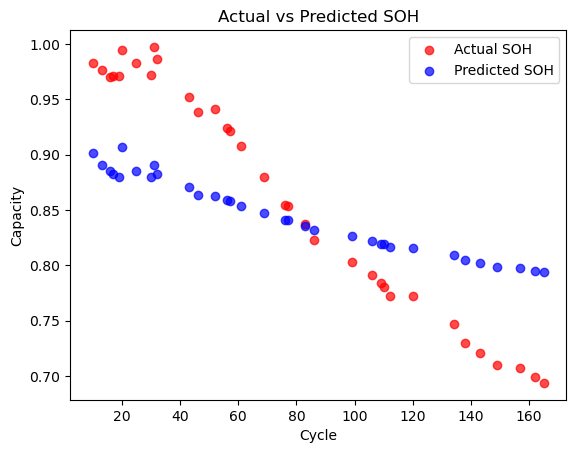

In [33]:
plt.scatter(test_df['Cycle'], test_df['Actual SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(test_df['Cycle'], test_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.show()

In [34]:
new_df = max_discharge_df.copy()

model = SVR(kernel='rbf')
model.fit(X, y)

y_pred = model.predict(X)
new_df['Predicted SOH'] = y_pred

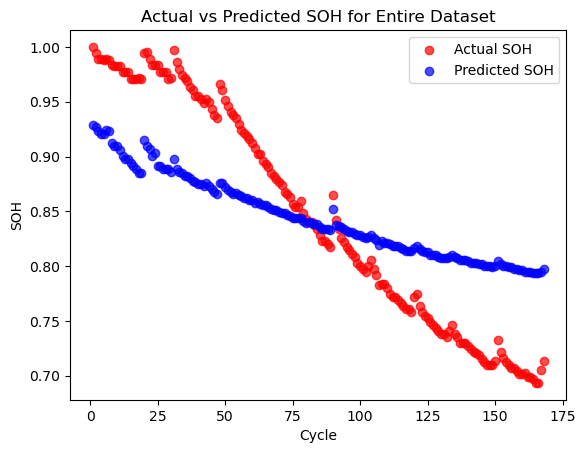

In [35]:
plt.scatter(new_df['Cycle'], new_df['SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(new_df['Cycle'], new_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.title('Actual vs Predicted SOH for Entire Dataset')
plt.legend()
plt.show()

In [36]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [37]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 0.00
R^2 Score: 0.99


In [38]:
test_df = X_test.copy()
test_df['Actual SOH'] = y_test
test_df['Predicted SOH'] = y_pred
test_df['Cycle'] = max_discharge_df.loc[X_test.index, 'Cycle']

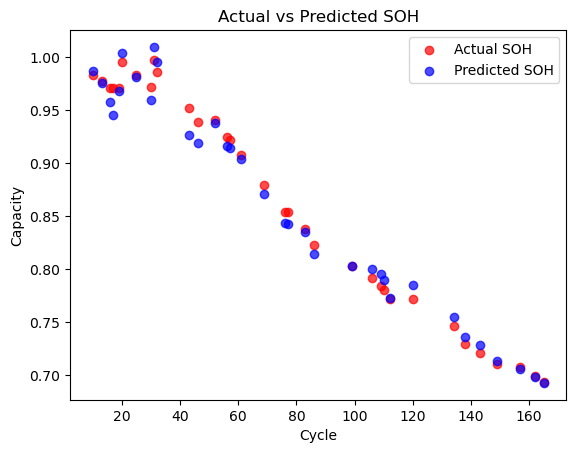

In [39]:
plt.scatter(test_df['Cycle'], test_df['Actual SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(test_df['Cycle'], test_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Actual vs Predicted SOH')
plt.legend()
plt.show()

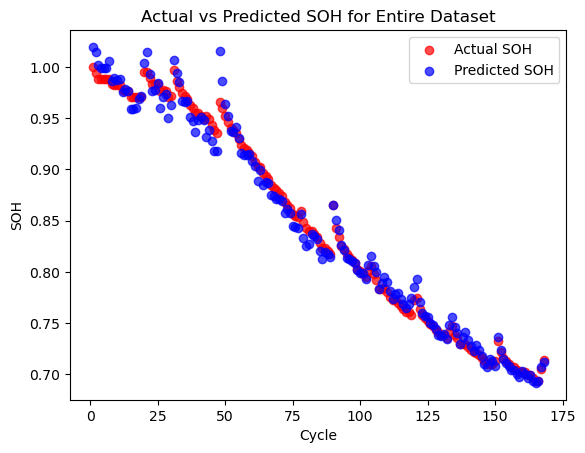

In [40]:
new_df = max_discharge_df.copy()

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
new_df['Predicted SOH'] = y_pred
plt.scatter(new_df['Cycle'], new_df['SOH'], color='red', label='Actual SOH', alpha=0.7)

plt.scatter(new_df['Cycle'], new_df['Predicted SOH'], color='blue', label='Predicted SOH', alpha=0.7)

plt.xlabel('Cycle')
plt.ylabel('SOH')
plt.title('Actual vs Predicted SOH for Entire Dataset')
plt.legend()
plt.show()

## Combining charge and discharge

In [41]:
battery_dict.keys()

dict_keys(['B0005_charge', 'B0005_discharge', 'B0005_impedance', 'B0006_charge', 'B0006_discharge', 'B0006_impedance', 'B0007_charge', 'B0007_discharge', 'B0007_impedance', 'B0018_charge', 'B0018_discharge', 'B0018_impedance'])

In [42]:
battery_dict['B0005_charge'].head(2)

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570


In [43]:
battery_dict['B0005_discharge'].head(2)

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,SOH
0,1,0.000,4.191492,-0.004902,24.330034,-0.0006,0.000,1.856487,1.0
1,1,16.781,4.190749,-0.001478,24.325993,-0.0006,4.206,1.856487,1.0


In [44]:
def combine_dataset(battery_dictionary):
    combine_dfs = []

    for battery_name, battery_data in battery_dictionary.items():
        if 'impedance' not in battery_name:
            battery_df = battery_data.copy()
            battery_df['Battery'] = battery_name.split('_')[0]

            if '_charge' in battery_name:
                battery_df['Type'] = 'Charge'
            else:
                battery_df['Type'] = 'Discharge'

            combine_dfs.append(battery_df)

    combined_df = pd.concat(combine_dfs, ignore_index=True)
    return combined_df

In [45]:
total_battery_df = combine_dataset(battery_dict)
total_battery_df = total_battery_df.drop(columns=['SOH'])
total_battery_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003,B0005,Charge,NaN
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570,B0005,Charge,NaN
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726,B0005,Charge,NaN
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742,B0005,Charge,NaN
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753,B0005,Charge,NaN


In [46]:
def fill_missing_capacity_soh(df):
    # grouped = df.groupby(['Battery', 'Cycle'])
    # df['Capacity'] = grouped['Capacity'].transform(lambda x: x.ffill().bfill())

    def fill_group(group):
        capacity_value = group['Capacity'].dropna().unique()

        if len(capacity_value) == 1:
            group['Capacity'] = capacity_value[0]

        return group

    df = df.groupby(['Battery', 'Cycle']).apply(fill_group)

    return df.reset_index(drop=True)

In [47]:
total_battery_df = fill_missing_capacity_soh(total_battery_df)
total_battery_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003,B0005,Charge,1.856487
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570,B0005,Charge,1.856487
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726,B0005,Charge,1.856487
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742,B0005,Charge,1.856487
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753,B0005,Charge,1.856487


In [48]:
def get_missing_data(df):
    missing_data = df.isnull().sum().reset_index()
    missing_data.columns = ['Column', 'Missing Count']
    missing_data['Missing Percentage'] = (missing_data['Missing Count'] / len(df)) * 100
    return missing_data.sort_values(by='Missing Percentage', ascending=False)


get_missing_data(total_battery_df)

,Column,Missing Count,Missing Percentage
9,Capacity,13692,0.655418
2,Voltage_measured,2,0.000096
3,Current_measured,2,0.000096
4,Temperature_measured,2,0.000096
0,Cycle,0,0.000000
1,Time,0,0.000000
5,Current_charge,0,0.000000
6,Voltage_charge,0,0.000000
7,Battery,0,0.000000
8,Type,0,0.000000


In [49]:
rows_with_missing_data = total_battery_df[total_battery_df.isnull().any(axis=1)]
rows_with_missing_data

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
587849,169,0.000,3.703203,-0.004051,24.671571,0.000,0.003,B0005,Charge,NaN
587850,169,2.484,3.337711,-3.788460,24.675326,-3.788,1.511,B0005,Charge,NaN
587851,169,5.109,3.827229,1.510266,24.685090,1.498,4.558,B0005,Charge,NaN
587852,169,7.609,3.839275,1.510364,24.693961,1.500,4.580,B0005,Charge,NaN
587853,169,10.140,3.847181,1.511206,24.705552,1.500,4.586,B0005,Charge,NaN
...,...,...,...,...,...,...,...,...,...,...
2089045,134,9956.984,4.180760,-0.001612,23.160264,0.000,-0.007,B0018,Charge,NaN
2089046,134,9964.031,4.181660,-0.002837,23.166556,0.000,-0.007,B0018,Charge,NaN
2089047,134,9971.078,4.182311,-0.002382,23.163557,0.000,-0.007,B0018,Charge,NaN
2089048,134,9978.125,4.182857,-0.002210,23.153626,0.000,-0.007,B0018,Charge,NaN


In [50]:
total_battery_df = total_battery_df.dropna()
total_battery_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Battery,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.0000,0.003,B0005,Charge,1.856487
1,1,2.532,3.479394,-4.030268,24.666480,-4.0360,1.570,B0005,Charge,1.856487
2,1,5.500,4.000588,1.512731,24.675394,1.5000,4.726,B0005,Charge,1.856487
3,1,8.344,4.012395,1.509063,24.693865,1.5000,4.742,B0005,Charge,1.856487
4,1,11.125,4.019708,1.511318,24.705069,1.5000,4.753,B0005,Charge,1.856487
...,...,...,...,...,...,...,...,...,...,...
2086180,132,2686.359,3.443760,-0.002426,35.383979,0.0006,0.000,B0018,Discharge,1.341051
2086181,132,2700.546,3.453271,-0.000981,35.179732,0.0006,0.000,B0018,Discharge,1.341051
2086182,132,2714.640,3.461963,0.000209,34.977000,0.0006,0.000,B0018,Discharge,1.341051
2086183,132,2728.750,3.469907,0.001516,34.785943,0.0006,0.000,B0018,Discharge,1.341051


In [51]:
get_missing_data(total_battery_df)

,Column,Missing Count,Missing Percentage
0,Cycle,0,0.0
1,Time,0,0.0
2,Voltage_measured,0,0.0
3,Current_measured,0,0.0
4,Temperature_measured,0,0.0
5,Current_charge,0,0.0
6,Voltage_charge,0,0.0
7,Battery,0,0.0
8,Type,0,0.0
9,Capacity,0,0.0


## Modelling Proper

In [73]:
b18_df = total_battery_df[total_battery_df.Battery == 'B0018']
b18_df = b18_df.drop('Battery', axis=1)
b18_df = pd.get_dummies(b18_df, columns=['Type'], drop_first=True)
b18_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,Type_Discharge
1774374,1,0.000,3.865713,0.001014,23.735721,0.000,-0.007,1.855005,False
1774375,1,2.484,3.447651,-4.034445,23.743956,-4.036,1.553,1.855005,False
1774376,1,5.109,4.005559,1.517435,23.773723,1.507,4.721,1.855005,False
1774377,1,7.562,4.015989,1.514558,23.777077,1.507,4.737,1.855005,False
1774378,1,10.062,4.023230,1.517284,23.792710,1.507,4.743,1.855005,False


In [74]:
battery_df = total_battery_df[total_battery_df['Battery'].isin(['B0005', 'B0006', 'B0007'])].drop(columns=['Battery'])
battery_df

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Type,Capacity
0,1,0.000,3.873017,-0.001201,24.655358,0.0000,0.003,Charge,1.856487
1,1,2.532,3.479394,-4.030268,24.666480,-4.0360,1.570,Charge,1.856487
2,1,5.500,4.000588,1.512731,24.675394,1.5000,4.726,Charge,1.856487
3,1,8.344,4.012395,1.509063,24.693865,1.5000,4.742,Charge,1.856487
4,1,11.125,4.019708,1.511318,24.705069,1.5000,4.753,Charge,1.856487
...,...,...,...,...,...,...,...,...,...
1770760,168,2781.312,3.336677,-0.002464,38.744012,0.0006,0.001,Discharge,1.432455
1770761,168,2791.062,3.349952,-0.005358,38.462399,0.0006,0.001,Discharge,1.432455
1770762,168,2800.828,3.362104,-0.003906,38.246805,0.0006,0.001,Discharge,1.432455
1770763,168,2810.640,3.373357,-0.002763,37.970504,0.0006,0.001,Discharge,1.432455


In [75]:
battery_df = pd.get_dummies(battery_df, columns=['Type'], drop_first=True)
battery_df.head()

,Cycle,Time,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Capacity,Type_Discharge
0,1,0.000,3.873017,-0.001201,24.655358,0.000,0.003,1.856487,False
1,1,2.532,3.479394,-4.030268,24.666480,-4.036,1.570,1.856487,False
2,1,5.500,4.000588,1.512731,24.675394,1.500,4.726,1.856487,False
3,1,8.344,4.012395,1.509063,24.693865,1.500,4.742,1.856487,False
4,1,11.125,4.019708,1.511318,24.705069,1.500,4.753,1.856487,False


In [76]:
y = battery_df['Capacity']
X = battery_df.drop('Capacity', axis=1)

In [77]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [78]:
y_train = y
X_train = sc.fit_transform(X)

y_test = b18_df['Capacity']
X_test = sc.fit_transform(b18_df.drop('Capacity', axis=1))

In [125]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def model_eval(y_test, prediction_dict):
    eval_results = {}

    for model_name, y_pred in prediction_dict.items():
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        mask = y_test != 0
        mape = np.mean(np.abs((y_test[mask] - y_pred[mask])) / y_test[mask]) * 100

        r2 = r2_score(y_test, y_pred)

        eval_results[model_name] = {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2 Score': r2
        }

    eval_df = pd.DataFrame(eval_results).T
    eval_df['Model'] = eval_df.index
    eval_df.reset_index(drop=True, inplace=True)

    return eval_df

## LinearSVR

In [79]:
from sklearn.svm import LinearSVR

linear_svr_model = LinearSVR(random_state=42)
linear_svr_model.fit(X_train, y_train)

C:\Users\Roman Shrestha\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Roman Shrestha\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=42)

In [93]:
y_pred_lsvr = linear_svr_model.predict(X_test)

## Linear Regression

In [87]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred_lr = linear_svr_model.predict(X_test)

## SGDRegressor

In [117]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RepeatedKFold

sgd_regressor = SGDRegressor(max_iter=1000)

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=101)

param_sgd = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'fit_intercept': [True, False],
    'eta0': [0.1, 0.01, 0.001],
    'penalty': ['elasticnet', 'l1', 'l2']
}

search_sgd = GridSearchCV(sgd_regressor, param_sgd, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)

result_sgd = search_sgd.fit(X_train, y_train)
y_pred_sgd = search_sgd.predict(X_test)

In [118]:
print(f'Root Mean Square Error: {-result_sgd.best_score_:.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred_sgd):.4f}')
print(f'R2 Score: {r2_score(y_test, y_pred_sgd):.4f}')
print('Best Hyperparameters:', result_sgd.best_params_)

Root Mean Square Error: 0.0657
Mean Absolute Error: 0.0540
R2 Score: 0.8254
Best Hyperparameters: {'alpha': 0.0001, 'eta0': 0.001, 'fit_intercept': True, 'penalty': 'l2'}


## XGBoost

In [120]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)

xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [121]:
y_pred_xgb = xgb_regressor.predict(X_test)

In [136]:
prediction_dict = {
    'Linear Regression': y_pred_lr,
    'LinearSVR': y_pred_lsvr,
    'SGD Regressor': y_pred_sgd,
    'XGBoost Regressor': y_pred_xgb
}

eval_df = model_eval(y_test, prediction_dict)
eval_df

,RMSE,MAE,MAPE,R2 Score,Model
0,0.073442,0.059275,3.862844,0.786648,Linear Regression
1,0.073442,0.059275,3.862844,0.786648,LinearSVR
2,0.066438,0.053979,3.472675,0.825401,SGD Regressor
3,0.058610,0.045650,2.975731,0.864123,XGBoost Regressor


In [147]:
def plot_scores(df):
    score_types = {
        'RMSE': 'skyblue',
        'MAE': 'lightgreen',
        'MAPE': 'salmon',
        'R2 Score': 'orange'
    }

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    axs = axs.flatten()

    for idx, (score_type, color) in enumerate(score_types.items()):
        axs[idx].plot(df['Model'], df[score_type], color=color, marker='o', linestyle='-', linewidth=2, markersize=8,
                      label='Line')
        axs[idx].scatter(df['Model'], df[score_type], color=color, s=100, label='Points')

        axs[idx].set_title(score_type)
        axs[idx].set_ylabel(score_type.split()[0])
        axs[idx].legend()

        axs[idx].set_xticks(df['Model'])
        axs[idx].set_xticklabels(df['Model'], rotation=45, ha='right')
        axs[idx].get_legend().remove()

    plt.tight_layout()
    plt.show()

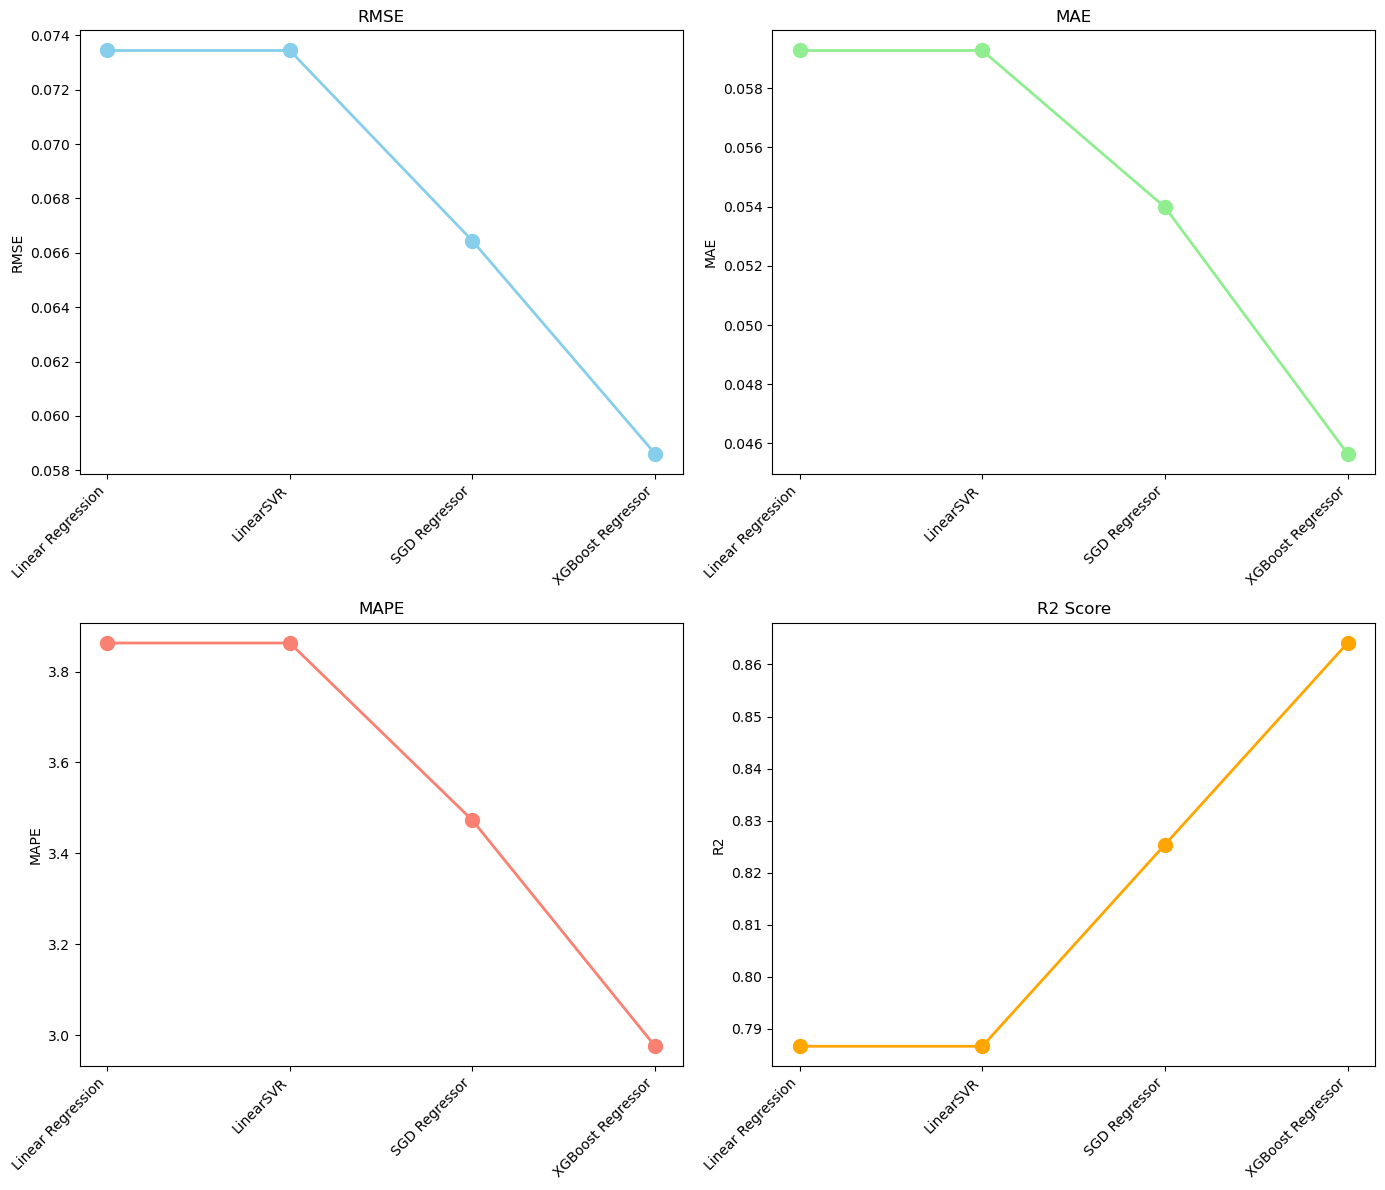

In [148]:
plot_scores(eval_df)